# Extract image segment of the contents of the 'element' column in catalogues

sample test catalogue: Master Catalogue no.6, scan0220.pdf page 6

In [61]:
import os
import json
import difflib
import re
from enum import Enum
from sklearn.cluster import dbscan

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [24]:
catalogue_path = '/home/riikoro/fossil_data/Master Catalogues/Master Catalogue No.6-53995-59999/scan0220.pdf'
page = 6

### Helper functions

(from data science project code)

In [57]:
class StandardHeaders(Enum):
    """
    Contains the standardized header values for the scanned documents.
    You can call 'StandardHeaders.to_list()' to convert this into a list

    Note: these are used to find headers from PDFs. Do not add any header that is not
    on the PDFs or is in a downstream format
    """
    # in this order
    KNM = "KNM"
    LOC_INN = "LOC. INN."
    ACC_NO = "ACC. NO."
    TAXON = "TAXON"
    ELEMENT = "ELEMENT"
    FIELD_NO = "FIELD NO."
    CLASSIFICATION = "CLASSIFICATION"
    LOCALITY = "LOCALITY"
    DESCRIPTION = "DESCRIPTION"

    @staticmethod
    def to_list():
        return [header.value for header in StandardHeaders]

    @staticmethod
    def to_table_list():
        return [to_table_format(header.value) for header in StandardHeaders]


def read_jsons_to_df_list(dir_path: str, page_num: int):
    dir_path = '_'.join([dir_path, 'pages'])
    if not os.path.isdir(dir_path):
        raise FileNotFoundError('Invalid path')

    first_page_path = os.path.join(dir_path, f'page{page_num}.json')
    if not os.path.exists(first_page_path):
        raise FileNotFoundError(f'Could not find page in path {first_page_path}')

    json_path = os.path.join(dir_path, f'page{page_num}.json')
    page_df = read_json_words_to_df(json_path)

    return page_df

def read_json_words_to_df(json_path: str) -> pd.DataFrame:
    """Get pd.DataFrame with bounding box details derived from given JSON file.

    The dataframe will have the following columns:
    'text', 'confidence'
    'x_ul', 'x_ur', 'x_ll', 'x_lr',
    'y_ul', 'y_ur', 'y_ll', 'y_lr',
    'x_center', 'y_center'.

    :param json_path:
    :return: pd.DataFrame:
    """
    with open(json_path) as f:
        json_obj = json.load(f)
    x_upper_left = []
    x_upper_right = []
    x_lower_left = []
    x_lower_right = []

    y_upper_left = []
    y_upper_right = []
    y_lower_left = []
    y_lower_right = []

    text = []
    confidence = []
    for sentence in json_obj['readResult']['blocks'][0]['lines']:
        for box in sentence['words']:
            text.append(box['text'])
            confidence.append(box['confidence'])

            bp = box['boundingPolygon']
            x_upper_left.append(bp[3]['x'])
            x_upper_right.append(bp[2]['x'])
            x_lower_left.append(bp[0]['x'])
            x_lower_right.append(bp[1]['x'])

            y_upper_left.append(bp[3]['y'])
            y_upper_right.append(bp[2]['y'])
            y_lower_left.append(bp[0]['y'])
            y_lower_right.append(bp[1]['y'])

        box_df = pd.DataFrame(
            {
                'text': text,
                'confidence': confidence,
                'x_ul': x_upper_left,
                'x_ur': x_upper_right,
                'x_ll': x_lower_left,
                'x_lr': x_lower_right,

                'y_ul': y_upper_left,
                'y_ur': y_upper_right,
                'y_ll': y_lower_left,
                'y_lr': y_lower_right
            }
        )
        box_df['x_center'] = (box_df['x_ul'] + box_df['x_ur'] + box_df['x_ll'] + box_df['x_lr']) / 4
        box_df['y_center'] = (box_df['y_ul'] + box_df['y_ur'] + box_df['y_ll'] + box_df['y_lr']) / 4

    return box_df
    
def read_pdf_to_images(
    pdf_root_path: str,
    page_num: int = None,
) -> np.ndarray:
    dir_path = '_'.join([pdf_root_path, 'pages'])
    img_path = os.path.join(dir_path, f'page{page_num}.png')
    return cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

### Table inference helpers

In [89]:
def dbscan_evaluation(features: np.array, labels: np.array) -> int:
    """Score clustering performance according to the variance of distances between consecutive cluster means.

    :param features: Features.
    :param labels: Predicted cluster labels.
    :return: Score value.
    """
    # remove occurrences with no resulting label (that were too noisy for clustering)
    # these are labeled as -1 by DBSCAN
    df = pd.DataFrame(
        {
            'feature': features,
            'label': labels
        }
    )
    df['label'] = df['label'].replace(-1, np.nan)
    df = df.dropna()

    # count mean feature value in each cluster
    feature_means = []
    for label in df['label'].unique():
        mask = df['label'] == label
        cluster_features = df['feature'][mask]
        feature_means.append(cluster_features.mean())

    # compute distances between means of consecutive rows
    dist = np.diff(feature_means)

    # score is defined as the variance of the distances
    # np.var on empty array throws error -> variance of empty array of distances is zero
    # (occurs on pages with 0-2 lines)
    if (dist.size > 0):
        score = np.var(dist)
    else:
        score = 0

    return score


def dbscan_hyper_parameter_grid_search(
        features,
        eps_start: int,
        eps_stop: int,
        min_samples_start: int,
        min_samples_stop: int,
        metric: str = 'euclidean'
) -> tuple[int, int]:
    """Perform gridsearch for DBSCAN to find optimal hyperparameter values for eps and min_samples.

    :param features:
    :param eps_start:
    :param eps_stop:
    :param min_samples_start:
    :param min_samples_stop:
    :param metric:
    :return: Optimal eps and min_samples values.
    """
    # perform gridsearch for dbscan with value ranges
    # for eps and min samples parameters
    eps_list = []
    min_samples_list = []
    score_list = []
    for eps in range(eps_start, eps_stop + 1):
        for min_samples in range(min_samples_start, min_samples_stop + 1):
            _, labels = dbscan(
                pd.DataFrame(features),
                eps=eps,
                min_samples=min_samples,
                metric=metric)
            score = dbscan_evaluation(features, labels)
            eps_list.append(eps)
            min_samples_list.append(min_samples)
            score_list.append(score)
    grid_search_df = pd.DataFrame(
        {
            'eps': eps_list,
            'min_samples': min_samples_list,
            'score': score_list
        }
    )
    grid_search_df.sort_values(by='score', inplace=True)
    best_eps = grid_search_df['eps'][0]
    best_min_values = grid_search_df['min_samples'][0]

    return best_eps, best_min_values


def dbscan_infer_structure(
        features,
        eps_start: int = 30,
        eps_stop: int = 40,
        min_samples_start: int = 2,
        min_samples_stop: int = 2
) -> list[int]:
    """Cluster bounding boxes according to either center x or y -value (col or row).

    :param features: Iterable of features.
    :param eps_start:
    :param eps_stop:
    :param min_samples_start:
    :param min_samples_stop:
    :return: List of inferred labels.
    """
    eps, min_samples = dbscan_hyper_parameter_grid_search(
        features,
        eps_start,
        eps_stop,
        min_samples_start,
        min_samples_stop
    )
    _, labels = dbscan(pd.DataFrame(features), eps=eps, min_samples=min_samples, metric='euclidean')
    return labels


def dbscan_infer_cols(x) -> list[int]:
    """Infer column labels using DBSCAN algorithm.

    :param x: X-coordinates of the centroids of the bounding boxes.
    :return: Column labels as a list of integers.
    """
    col_labels = dbscan_infer_structure(x, eps_start=36)
    return col_labels


def dbscan_infer_rows(y) -> list[int]:
    """Infer row labels using DBSCAN algorithm.

    :param y: Y-coordinates of the centroids of the bounding boxes.
    :return: Row labels as a list of integers.
    """
    row_labels = dbscan_infer_structure(y)
    return row_labels

def to_table_format(header_text):
    return header_text.replace('.', '').replace(' ', '_')

KNOWN_HEADERS = [
    "loc inn",
    "acc no",
    "taxon",
    "element",
    "field no",
    "locality",
    "original knm no",
    "new knm no",
    "original taxon",
    "new taxon",
    "classification",
    "loc",
    "loc initials",
    "loc inits",
    "knm",
    "acc #",
    "field #"
]

MULTI_WORD_STARTS = ['ACC.', 'FIELD', 'LOC.']

MULTI_WORD_ENDS = ['NO.', 'INN.']

# find all words that are present in common_cols from data
def word_in_common_colnames(word_row: pd.Series):
    word = word_row['text']
    word = word.lower()
    word = word.replace('.', '')
    word = word.replace('-', '')
    common_col_word_separated = []
    for header in KNOWN_HEADERS:
        parts = header.split(' ')
        common_col_word_separated.extend(parts)
    return word in common_col_word_separated

def fix_header_typos(headers: pd.DataFrame):
    common_words = []
    for header in StandardHeaders.to_list():
        common_words.extend(header.split(' '))

    # get unique values
    common_words = [ _ for _ in set(common_words)]

    for i, header in headers.iterrows():
        content = header['text']
        content_transformed = content.upper()
        match = difflib.get_close_matches(possibilities=common_words, word=content_transformed)

        new_header = match[0] if len(match) > 0 else content_transformed
        headers.loc[i,'text'] = new_header

    return headers

def combine_multi_word_headers(headers: pd.DataFrame):
    # sort headers by x-center to find the next header on the right for each header
    headers = headers.sort_values(by='x_center')

    headers_final = pd.DataFrame()
    for i, header in headers.iterrows():
        word = header['text']
        if word in MULTI_WORD_STARTS:
            combined = header.copy()
            # header is the first word of a multi header
            end = 'INN.' if word == 'LOC.' else 'NO.'

            combined['text'] = f"{header['text']} {end}"
            try:
                # combine bounding boxes
                if headers.loc[i+1]['text'] == end:
                    # create combined bounding box: box around both words
                    left = x_coord_array(header).min()
                    right = x_coord_array(headers[i+1]).max()
                    top = y_coord_array(header).max()
                    bottom = y_coord_array(header).min()
                    combined['x_ul'] = left
                    combined['x_ll'] = left
                    combined['x_ur'] = right
                    combined['x_lr'] = right

                    combined['y_ul'] = top
                    combined['y_ll'] = bottom
                    combined['y_ur'] = top
                    combined['y_lr'] = bottom
            except KeyError: # when handling last header on the right, no modifications for bounding box
                pass
            headers_final = pd.concat([headers_final, combined.to_frame().T])
        elif word not in MULTI_WORD_ENDS:
            headers_final = pd.concat([headers_final, header.to_frame().T])

    return headers_final

def mode(x: np.array):
    unique_elements, counts = np.unique(x, return_counts=True)
    max_count = np.max(counts) # TODO: throws error when x is empty (no common colnames found. clue that page is not a table)
    modes = unique_elements[counts == max_count]
    return modes[0]

def header_has_text(header: pd.Series):
    punctuation_or_digits_only_pattern = r'[^\w\s]|[\d]'
    header_text = header['text']
    header_no_punc = re.sub(punctuation_or_digits_only_pattern, '', header_text)
    return len(header_no_punc) > 0

def find_table_headers(page: pd.DataFrame):
    '''
    Find headers on page. returns dataframe containing all headers.
    '''
    header_suspects = page[page.apply(word_in_common_colnames, axis=1)]

    if (df_row_count(header_suspects) == 0):
        raise NotATableException(f'Found no standard headers on page')

    # find rows
    page['row_id'] = dbscan_infer_rows(page['y_center'])
    # find words that are on the same rows as most common headers
    header_rowids = np.array(page.loc[header_suspects.index]['row_id'])
    header_row = mode(header_rowids)
    headers = page[page['row_id'] == header_row]

    headers = fix_header_typos(headers)

    headers = headers[headers.apply(header_has_text, axis=1)]

    headers = combine_multi_word_headers(headers)

    # Transform headers into table format (remove dot, replace space with underscore)
    table_headers = list(
        map(lambda x: x
            if x not in StandardHeaders.to_list()
            else to_table_format(x)
            , headers['text']
        )
    )
    headers['text'] = table_headers

    #
    # Not a table-checkers
    #

    # there is <= one standard header after all combining and page-fixing
    standard_headers_on_page = headers.loc[headers['text'].isin(StandardHeaders.to_list())]
    count_of_unique_standard_headers = len(set(standard_headers_on_page['text']))
    if (count_of_unique_standard_headers <= 1):
        raise NotATableException(f'Page had one or less standard-form headers')

    # header row is super long (tables have definitely less than 20 headers)
    # eg. official catalogue p. 98
    if (len(headers) > 20):
        raise NotATableException(f'Page had {len(headers)} headers')

    return headers

class MetadataHeaders(Enum):
    """
    Contains the metadata column header names for scanned pdfs.
    You can call 'MetadataHeaders.to_list()' to convert this into a list
    """
    PAGE = "page"
    N_COLS = "n_cols"
    ROW_ON_PAGE = "row_on_page"
    SOURCE = "source"
    RED_DOT = "red_dot"
    GREEN_DOT = "green_dot"
    CONFIDENCE = "confidence"

    @staticmethod
    def to_list():
        return [header.value for header in MetadataHeaders]

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def x_coord_array(word: pd.Series):
    return np.array([word['x_ul'], word['x_ll'], word['x_ur'], word['x_lr']])

def y_coord_array(word):
    return np.array([word['y_ul'], word['y_ll'], word['y_ur'], word['y_lr']])

def df_row_count(df: pd.DataFrame):
    return len(df.index)

def get_header_x_locations(headers: pd.DataFrame):
    column_xcoords = []
    for i, header in headers.iterrows():
        xcoord_left = x_coord_array(header).min()
        xcoord_right = x_coord_array(header).max()
        column_xcoords.append((xcoord_left, xcoord_right))

    def sorter(item: tuple):
        return item[0]
    column_xcoords = sorted(column_xcoords, key=sorter)
    return column_xcoords


def divide_words_to_columns(page: pd.DataFrame, column_locations):
    column_means = [(xcoord[1]+xcoord[0])/2 for xcoord in column_locations]

    for i, word in page.iterrows():
        xs = x_coord_array(word)
        col_id = find_nearest(column_means, xs.mean())
        page.loc[i, 'col_id'] = col_id
    
    return page


def combine_words_in_same_cell(page: pd.DataFrame, headers: pd.DataFrame):
    diff_measure = 15

    header_count = len(headers.index)
    for header_id in range(header_count):
        words_in_column = page[page['col_id'] == header_id]
        new_words = pd.DataFrame()  # accumulate combined words to new dataframe

        i = 0  # index in dataframe is not 0, 1, 2 on this column
        current_cell = pd.Series(dtype=object)
        for word_id, word in words_in_column.iterrows():
            if current_cell.empty:
                current_cell = word
                continue

            if abs(current_cell['y_center']-word['y_center']) < diff_measure:
                # combine two words
                current_cell['text'] = f"{current_cell['text']} {word['text']}"
                # combine bounding boxes
                left = x_coord_array(current_cell).min()
                right = x_coord_array(word).max()
                top = y_coord_array(current_cell).max()
                bottom = y_coord_array(word).min()

                current_cell['x_ul'] = left
                current_cell['x_ll'] = left
                current_cell['x_ur'] = right
                current_cell['x_lr'] = right

                current_cell['y_ul'] = top
                current_cell['y_ll'] = bottom
                current_cell['y_ur'] = top
                current_cell['y_lr'] = bottom

                # confidence: take average
                current_cell['confidence'] = (current_cell['confidence'] + word['confidence']) / 2
            else:
                new_words = pd.concat([new_words, current_cell.to_frame().T])
                current_cell = word
            i += 1
        page.drop(page[page['col_id'] == header_id].index, inplace=True)
        page = pd.concat([page, new_words])
    return page


def make_table(page: pd.DataFrame, headers: pd.DataFrame):
    print(page)
    row_df = page.groupby('row_id')['y_center'].mean().reset_index()
    num_rows = page['row_id'].max()
    confidence = page.groupby('row_id')['confidence'].min().reset_index()
    table = pd.DataFrame(index=range(num_rows), columns=headers['text'])
    for i, row in page.iterrows():
        row_id = int(row['row_id']) - 1  # first row is header & was removed
        col_id = int(row['col_id'])
        table.iloc[row_id, col_id] = row['text']

    table['y_center'] = row_df['y_center']
    table[MetadataHeaders.CONFIDENCE.value] = confidence['confidence']
    table.sort_values(by=['y_center'], ascending=True, inplace=True)

    return table


def find_table_with_means(page: pd.DataFrame):
    # obtain headers
    headers = find_table_headers(page)

    # find min and max x-coordinates of each header
    column_locations = get_header_x_locations(headers)

    # divide words on page into arrays of words based on which words are in the same column
    page = divide_words_to_columns(page, column_locations)

    # find which words are in the same cell
    page = combine_words_in_same_cell(page, headers)

    # drop rows not clustered to any cluster (noise)
    # dbscan is sometimes unable to determine cluster for all inputs, assigns label -1 for them
    page = page[page['row_id'] != -1]

    # remove headers from data
    page.drop(page[page['row_id'] == 0].index, inplace=True)

    # construct dataframe based on row/col ids
    # table = make_table(page, headers) skip this to preserve row/col ids and bounding boxes!
    return page, headers

### Extract data

    text  confidence  x_ul  x_ur  x_ll  x_lr  y_ul  y_ur  y_ll  y_lr  \
0    KNM       0.761    26   148    24   147   309   303   232   231   
1    LE,       0.072   183   282   182   282   300   289   230   226   
2    Acc       0.977   370   493   370   494   319   320   214   214   
3      #       0.438   515   589   515   589   320   320   214   214   
4  TAXON       0.965   719  1061   722  1064   318   317   214   218   

   x_center  y_center  
0     86.25    268.75  
1    232.25    261.25  
2    431.75    266.75  
3    552.00    267.00  
4    891.50    266.75  


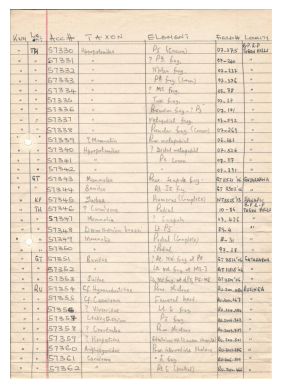

In [90]:
path_to_dir = catalogue_path
page_num = page
  
try:
    df = read_jsons_to_df_list(path_to_dir, page_num)
    image = read_pdf_to_images(path_to_dir,  page_num)
except FileNotFoundError as e:
    print(f'ERROR: {e}')
    exit(1)

print(df.head())
plt.axis('off')
plt.imshow(image)

In [95]:
page, headers = find_table_with_means(df)
print(headers)
print(page.head())

       text confidence  x_ul  x_ur  x_ll  x_lr y_ul y_ur y_ll y_lr x_center  \
1       LE,      0.072   183   282   182   282  300  289  230  226   232.25   
2    ACC_NO      0.977   370   493   370   494  319  320  214  214   431.75   
4     TAXON      0.965   719  1061   722  1064  318  317  214  218    891.5   
5   ELEMENT      0.993  1308  1692  1310  1690  293  288  231  233   1500.0   
6  FIELD_NO      0.972  1953  2111  1953  2112  296  295  241  243  2032.25   
8  LOCALITY      0.717  2218  2454  2219  2456  295  296  243  245  2336.75   

  y_center row_id col_id  
1   261.25      0    1.0  
2   266.75      0    2.0  
4   266.75      0    3.0  
5   261.25      0    4.0  
6   268.75      0    5.0  
8   269.75      0    6.0  
   text confidence x_ul x_ur x_ll x_lr y_ul y_ur y_ll y_lr x_center y_center  \
12   TH      0.967  193  256  193  256  428  428  367  367    224.5    397.5   
24   11      0.818  231  252  229  251  508  507  474  474   240.75   490.75   
31   11      0.86

In [110]:
element_col_id = int(headers.loc[headers['text'] == 'ELEMENT']['col_id'])
element_col_id

4

In [114]:
element_boxes = page.loc[page['col_id'] == element_col_id - 1.0] # col_id in headers starts from 1 and from 0 on the page
element_boxes 

,text,confidence,x_ul,x_ur,x_ll,x_lr,y_ul,y_ur,y_ll,y_lr,x_center,y_center,row_id,col_id
9,P5 (Crown),0.585,1344,1680,1344,1680,417,417,345,345,1384.75,377.25,1,3.0
21,? P4 frag.,0.74625,1314,1619,1314,1619,504,504,439,439,1334.0,469.75,2,3.0
27,Molar frag.,0.8185,1340,1660,1340,1660,609,609,548,548,1429.25,576.75,3,3.0
36,P & frag. (Crown),0.6865,1365,1758,1365,1758,692,692,634,634,1376.5,658.75,4,3.0
45,? Mx frag.,0.85825,1309,1605,1309,1605,787,787,733,733,1326.0,756.25,5,3.0
51,Tusk frag.,0.6965,1346,1632,1346,1632,891,891,829,829,1395.5,857.0,6,3.0
59,Premolar frag -?,0.79625,1325,1744,1325,1744,984,984,908,908,1432.75,947.25,7,3.0
67,Metabodial frage,0.613,1309,1748,1309,1748,1085,1085,1022,1022,1442.0,1050.5,8,3.0
74,Premolar frag. (,0.88675,1328,1723,1328,1723,1172,1172,1104,1104,1431.5,1139.25,9,3.0
82,Prox. metapodial,0.8575,1313,1702,1313,1702,1267,1267,1195,1195,1365.0,1229.5,10,3.0


## Crop image according to found bounding box

adjust +/- values according to image results (optimized now for this specific page)

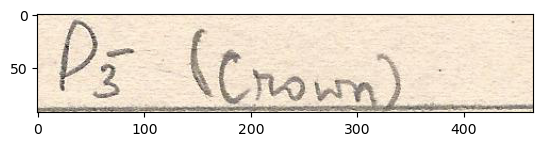

In [136]:
def crop_by_bounding_box(element_row: pd.Series, img: np.array):
    y1 = min(int(element_row['y_ur']), int(element_row['y_ul']))
    y2 = max(int(element_row['y_lr']), int(element_row['y_ll']))
    y_top = min(y1, y2) -10
    y_bottom = max(y1, y2) +10

    x1 = min(int(element_row['x_ll']), int(element_row['x_ul']))
    x2 = max(int(element_row['x_lr']), int(element_row['x_ur']))
    x_left = min(x1, x2) -10
    x_right = max(x1, x2) +120

    crop_img = img[y_top:y_bottom,x_left:x_right]
    return crop_img

plt.imshow(crop_by_bounding_box(element_boxes.iloc[0], image))

### Loop for saving cropped images to data dir

In [137]:
i = 0
while i < element_boxes.shape[0]:
    cropped = crop_by_bounding_box(element_boxes.iloc[i], image)
    cv2.imwrite(f'/home/riikoro/fossil_data/tooth_samples/v2/{i}.png', cv2.cvtColor(cropped, cv2.COLOR_RGB2BGR))
    i += 1